## Compare repeated scans between different phases of the survey
### A. Ordog, October 31, 2022

## Import packages

In [1]:
import imp
import os
import subprocess
import h5py
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator as HourLocator
from matplotlib.dates import MinuteLocator as MinuteLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.time import TimeDelta
from scipy import interpolate


## Select survey phase:

In [2]:
#### User input  - phases to compare: #####
phases = [1,2]
###########################################

dir_files = '/srv/data/dva/survey_azimuth_scans_noise_corr/'
#dir_files = '/srv/data/dva/survey_azimuth_scans/'

### Read in Persistent RFI Mask:

In [3]:
i = 0
RFI_mask_idx = []
with open('/srv/data/dva/RFIpersist_mask/RFIpersist_mask.txt') as fp:
    for line in fp:
        if i>0: 
            RFI_mask_idx.append(int(line.split()[0]))
        i=i+1
RFI_mask_idx = np.array(RFI_mask_idx)

## Define functions

In [4]:
def make_scan_phase_dictionary(phases,dir_files):

    if len(phases)<2:
        print('Error: must compare at least two phases')

    scandict = {} 
    scanids = []
    scan_phase = []

    #all_scans = os.popen('ls -1 -R '+dir_files+'dva_survey_phase*').read().split()
    all_scans = os.popen('ls -1 -R '+dir_files+'dva_survey_phase* |xargs -n1 basename').read().split()
    #print(all_scans)

    for i in range(1,len(all_scans)):
        #print(all_scans[i])
        scanids.append(all_scans[i][22:26])
        scan_phase.append(all_scans[i][16])
    
    scan_phase = np.asarray(scan_phase).astype(np.int)
    scanids = np.asarray(scanids).astype(np.int)

    for phase in phases:
        w = np.where(scan_phase == phase)[0]
        scandict.update({"phase"+str(phase): scanids[w]}) 

    return scandict


def get_overlapping_scan_ids(scandict,list_scans=True,*args,**kwargs):
    
    keys_list = list(scandict.keys())
    all_lists = [set(scandict[i]) for i in keys_list]
    
    if len(phases) == 2:
        phases_str = str(keys_list[0])+' & '+str(keys_list[1])
        overlap_scans = list(set.intersection(set(all_lists[0]),
                                              set(all_lists[1])))
    if len(phases) == 3:
        phases_str = str(keys_list[0])+' & '+str(keys_list[1]+' & '+str(keys_list[2]))
        overlap_scans = list(set.intersection(set(all_lists[0]),
                                              set(all_lists[1]),
                                              set(all_lists[2])))
        
    if list_scans:
        print(str(len(overlap_scans))+' overlapping scans \nbetween '+phases_str+':')
        print('')
        for scan in overlap_scans:
            print(scan)
       
    return overlap_scans

def read_in_scan(scan_id,dir_files,phase):
    
    scan = f"{scan_id:04}"
    file = h5py.File(dir_files+'dva_survey_phase'+str(phase)+'_raw_'+scan+'_gain_corr.h5','r')
    #file = h5py.File(dir_files+'dva_survey_phase'+str(phase)+'_raw_'+scan+'.h5','r')
    
    dataset = file['data']['beam_0']['band_SB0']['scan_0']
    
    freq = file['data']['beam_0']['band_SB0']['frequency']
    
    dec = dataset['metadata']['declination']
    ra = dataset['metadata']['right_ascension']
    el = dataset['metadata']['elevation']
    az = dataset['metadata']['azimuth']
    t = dataset['metadata']['utc']
    noise = dataset['metadata']['noise_state']
    trim_flag = dataset['metadata']['trim_scan_flag']
    
    RR = dataset['data'][:,0,:]
    LL = dataset['data'][:,1,:]
    reRL = dataset['data'][:,2,:]
    imRL = dataset['data'][:,3,:]
    
    print(t[0])
    
    return RR,LL,reRL,imRL,freq,dec,ra,el,az,t,noise,trim_flag


## Create dictionary of scans and list overlapping ones:

In [5]:
scandict = make_scan_phase_dictionary(phases,dir_files)

overlap_scans = get_overlapping_scan_ids(scandict,list_scans=True)


98 overlapping scans 
between phase1 & phase2:

2573
2578
2579
2581
2585
2587
2588
1569
1570
1571
1572
1573
1065
1578
1068
1072
1074
1078
56
57
58
576
65
2653
2655
1643
1645
1646
1140
1141
1142
629
630
132
133
134
647
2724
2725
2215
2223
2224
2225
1211
702
703
704
705
710
2796
2797
2286
1787
1278
1279
1280
1281
1791
1792
773
1286
271
272
274
278
2873
2363
2368
2369
1356
1358
1870
1360
849
852
853
854
855
351
352
357
2435
2436
1929
1930
1423
1430
1431
920
2505
2506
1998
1500
485
492
493
494
496


## Pick a scan to examine:

b'2022-06-12T10:43:19.200005Z'
b'2022-08-27T05:44:30.000001Z'
(1804,)
RR1 shape: (1804, 8250)
new_RR1 shape: (8250, 1800)
new_RR1 shape transpose: (1800, 8250)


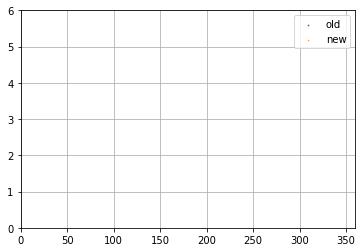

In [6]:
### User input - select scan from list above
# scan_pick = 576 #Good scan comparison
scan_pick = 1068
# scan_pick = 1280
############################################

# Note: the following assumes we are only comparing a single scan from TWO phases of the survey.
# Will generalize this later to allow for three phase-comparison and better naming scheme for
# the data read in.
RR1,LL1,reRL1,imRL1,freq1,dec1,ra1,el1,az1,t1,noise1,trim_flag1 = read_in_scan(scan_pick,dir_files,1)
noise1_idx = np.array(np.where(noise1 == 1))
RR1[noise1_idx, :] = np.nan
RR1[:,RFI_mask_idx] = np.nan
LL1[noise1_idx, :] = np.nan
LL1[:,RFI_mask_idx] = np.nan


RR2,LL2,reRL2,imRL2,freq2,dec2,ra2,el2,az2,t2,noise2,trim_flag2 = read_in_scan(scan_pick,dir_files,2)
noise2_idx = np.array(np.where(noise2 == 1))
RR2[noise2_idx, :] = np.nan
RR2[:,RFI_mask_idx] = np.nan
LL2[noise2_idx, :] = np.nan
LL2[:,RFI_mask_idx] = np.nan

# RR2 = RR2[ : -1] #Ignore the last idx in the RR2 array
# az2 = az2[ : -1]

# def Trim_Phases(RR1, az1, RR2, az2):
#     az1_len = len(az1)
#     az2_len = len(az2)
#     if (az1_len - az2_len) == 0:
#         print("stop condition")
#     elif az1_len > az2_len:
#         print("trim phase 1")
#     elif az2_len > az1_len:
#         print("trim phase 2")
    


x = [0.1, 1.2, 2.0, 3.1, 4.2] # 'old' x (azimuth)
y = [1., 2., 3., 4., 5.]      # 'old' y (power in LL, RR, reRL or imRL)



print(np.shape(az1))
print("RR1 shape:",np.shape(RR1))

# new_RR1.append(f1(new_az))
# ii = 900
# f1 = interpolate.interp1d(az1, RR1[:,ii], fill_value='extrapolate')
# new_RR1.append(f1(new_az))

# # new_RR1 = f1(new_az) # getting the 'new' y (power) interpolated over the evenly space az
# print("new_RR1 shape:", np.shape(new_RR1))
# print("new_RR1 shape transpose:", np.shape(np.transpose(new_RR1)))
# new_RR2 = f2(new_az)

# Interpolate Step -----------------------------------------------------------------------------
new_az = np.linspace(0, 360, 1800)
new_RR1 = []
new_RR2 = []
new_LL1 = []
new_LL2 = []
for freq_idx in range(0, len(RR1[0, :])):
    # The interpolation function:
    rr_f1 = interpolate.interp1d(az1, RR1[:,freq_idx], fill_value='extrapolate')
    rr_f2 = interpolate.interp1d(az2, RR2[:,freq_idx], fill_value='extrapolate')
    ll_f1 = interpolate.interp1d(az1, LL1[:,freq_idx], fill_value='extrapolate')
    ll_f2 = interpolate.interp1d(az2, LL2[:,freq_idx], fill_value='extrapolate')

    
    # getting the 'new' y (power) interpolated over the evenly space az
    new_RR1.append(rr_f1(new_az))
    new_RR2.append(rr_f2(new_az))
    new_LL1.append(ll_f1(new_az))
    new_LL2.append(ll_f2(new_az))

print("new_RR1 shape:", np.shape(new_RR1))
new_RR1 = np.transpose(new_RR1)
new_RR2 = np.transpose(new_RR2)
new_LL1 = np.transpose(new_LL1)
new_LL2 = np.transpose(new_LL2)
print("new_RR1 shape transpose:", np.shape(new_RR1))
# Interpolate Step -----------------------------------------------------------------------------


ii=850

plt.scatter(az1,RR1[:,ii],label='old',s=0.5)
plt.scatter(new_az,new_RR1[:,ii],label='new',s=0.2)
plt.xlim(0,360)
plt.ylim(0,6)
plt.legend()
plt.grid()

## Simple comparison plot at one frequency

477.10416666666663
477.10416666666663


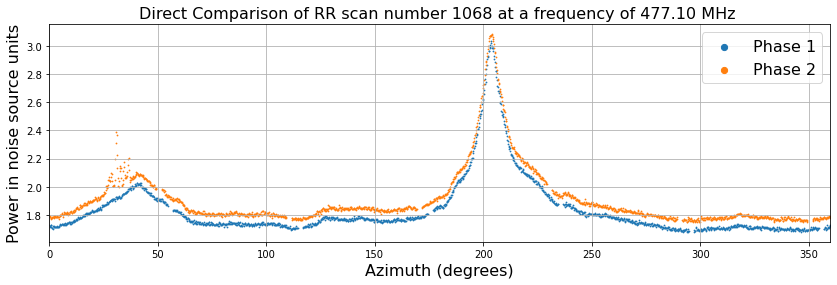

In [7]:
fig1, axs = plt.subplots(1,1,figsize=(14,4))

fs = 16
ii = 1600

t_plt1 = Time(t1, format='isot',scale='utc').mjd
t_plt2 = Time(t2, format='isot',scale='utc').mjd

axs.scatter(new_az,new_RR1[:, ii],s=0.6, label = "Phase 1")
axs.scatter(new_az,new_RR2[:, ii],s=0.6, label = "Phase 2")
# axs.set_ylim(1.5,2.5)
axs.set_xlim(0,360)
axs.set_xlabel('Azimuth (degrees)', fontsize = fs)
axs.set_ylabel('Power in noise source units', fontsize = fs)
axs.legend(fontsize= fs ,markerscale= 8 )
axs.grid()
plot_title = "Direct Comparison of RR scan number {0:02d} at a frequency of {1:.2f} MHz ".format(scan_pick, (freq1[ii]/1e6))
file_name = "Direct Comparison of RR scan number {} at a frequency of {} MHz.png".format(scan_pick, int(freq1[ii]/1e6))
axs.set_title(plot_title, fontsize = fs)

plt.savefig(file_name, facecolor = 'none')

print(freq1[ii]/1e6)
print(freq2[ii]/1e6)

In [8]:
def Get_Percent_Diff(A, B):
    diff = np.abs(np.subtract(A, B))
    rel_diff = diff/B #TODO: use the average instead of just B
    return np.abs(rel_diff*100)

def Get_RMS(arr):
    return np.sqrt(np.nanmean(arr**2))

def Write_Scan_Azimuth_Files(scan_pick):
    Scan_az_comparison_file = "scan_{:d}_az_comp.txt".format(scan_pick)
    with open(Scan_az_comparison_file, 'a') as fp:
        fp.write(str("az1      az2\n"))
        az1_len = len(az1)
        az2_len = len(az2)
        smallest_arr = np.min([az1_len, az2_len])
        for idx in range(0, smallest_arr - 1):
            fp.write("{:.3f}, {:.3f}\n".format(az1[idx], az2[idx]))
        if az1_len >= az2_len:
            #Finish writing az1
            for idx in range(smallest_arr-1, az1_len-1):
                fp.write("{:3f}, ".format(az1[idx]))
        else:
            #Finish writing az2
            for idx in range(smallest_arr-1, az2_len-1):
                fp.write("      ,{:3f}".format(az2[idx]))

IDEA: 
1- Mask out the noise sources
2- Get the difference between each data point
3- 

np.shape(RR1) (1800,)
np.shape(RR2) (1800,)
477.10416666666663
477.10416666666663
(1800,)


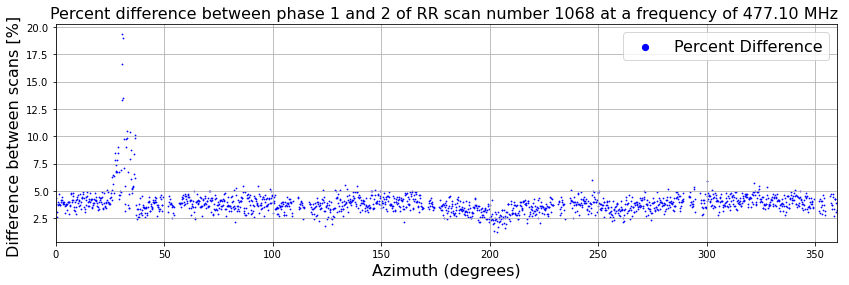

In [9]:
fig1, axs = plt.subplots(1,1,figsize=(14,4))

t_plt1 = Time(t1, format='isot',scale='utc').mjd
t_plt2 = Time(t2, format='isot',scale='utc').mjd
RR_diff = np.abs(np.subtract(new_RR1[:, ii],new_RR2[:, ii]))
RR_frac_diff = Get_Percent_Diff(new_RR1[:, ii], new_RR2[:, ii])

print("np.shape(RR1)", np.shape(new_RR1[:, ii]))
print("np.shape(RR2)", np.shape(new_RR2[:, ii]))

axs.scatter(new_az, RR_frac_diff, s = 0.6, color = 'b', label = "Percent Difference")
axs.set_xlim(0,360)
axs.set_xlabel('Azimuth (degrees)', fontsize = fs)
axs.set_ylabel('Difference between scans [%] ', fontsize = fs)
axs.legend()
axs.legend(fontsize= fs ,markerscale= 8)
axs.grid()
plot_title = "Percent difference between phase 1 and 2 of RR scan number {0:02d} at a frequency of {1:.2f} MHz ".format(scan_pick, (freq1[ii]/1e6))
file_name = "Percent difference between phase 1 and 2 of RR scan number {} at a frequency of {} MHz.png".format(scan_pick, int(freq1[ii]/1e6))
axs.set_title(plot_title, fontsize = fs)


plt.savefig(file_name, facecolor = 'none')

print(freq1[ii]/1e6)
print(freq2[ii]/1e6)
print(np.shape(RR_diff))

[385.44] MHz stats:
- RMS: 0.76
- Standard Deviation: 0.46
- Median: 0.51


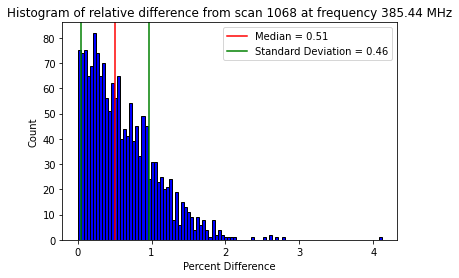

[410.44] MHz stats:
- RMS: 0.67
- Standard Deviation: 0.41
- Median: 0.44


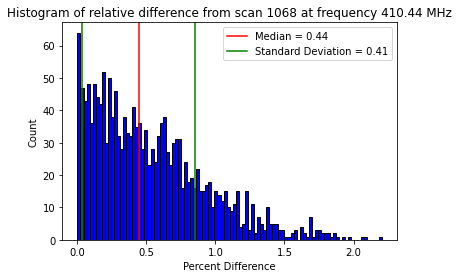

[427.10] MHz stats:
- RMS: 5.36
- Standard Deviation: 0.77
- Median: 5.34


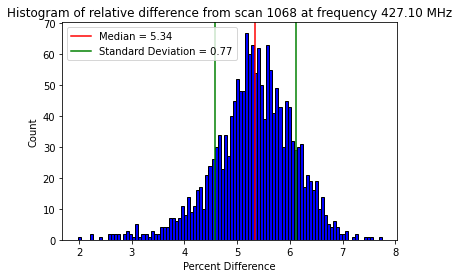

[477.10] MHz stats:
- RMS: 4.05
- Standard Deviation: 1.12
- Median: 3.82


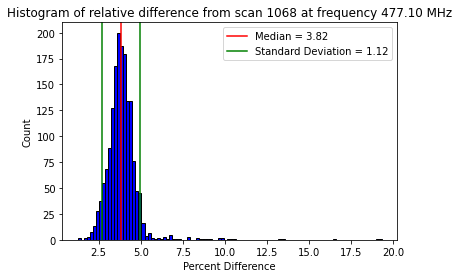

[843.77] MHz stats:
- RMS: 9.34
- Standard Deviation: 4.94
- Median: 6.44


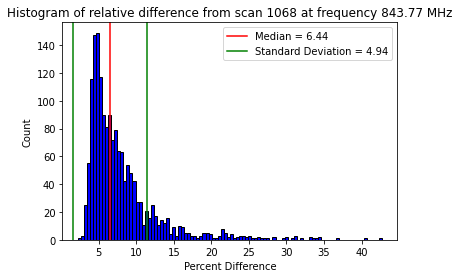

[927.10] MHz stats:
- RMS: 7.87
- Standard Deviation: 0.58
- Median: 7.85


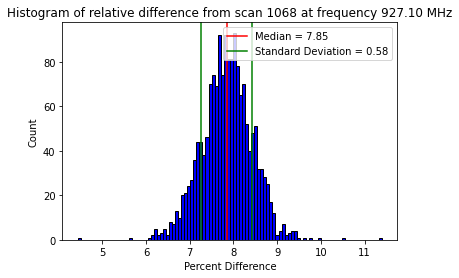

[943.77] MHz stats:
- RMS: 7.05
- Standard Deviation: 0.55
- Median: 7.03


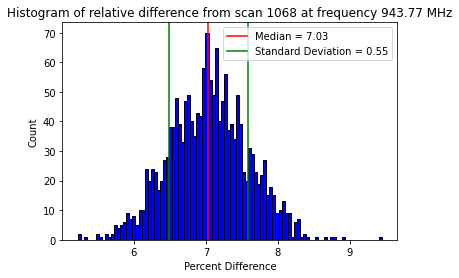

[960.44] MHz stats:
- RMS: 5.00
- Standard Deviation: 0.56
- Median: 4.96


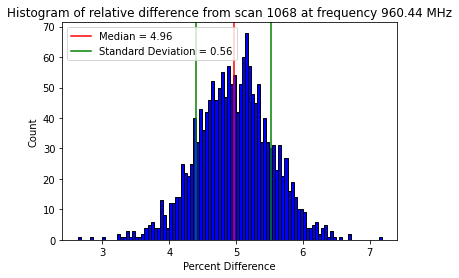

[977.10] MHz stats:
- RMS: 3.65
- Standard Deviation: 0.56
- Median: 3.62


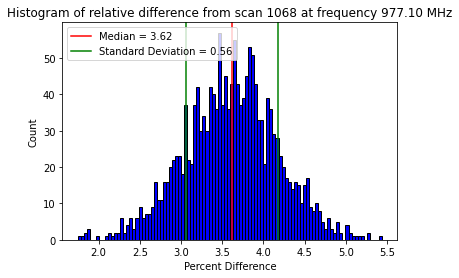

In [10]:
num_bins = 100
freq_chosen = [500, 800, 1000, 1600, 6000, 7000, 7200, 7400, 7600]
for freq_idx in freq_chosen:
    RR_frac_diff = Get_Percent_Diff(new_RR1[:, freq_idx], new_RR2[:, freq_idx])
    RR_median = np.nanmedian(RR_frac_diff)
    RR_mean = np.nanmean(RR_frac_diff) 
    RR_std = np.nanstd(RR_frac_diff)
    
    hist = plt.hist(RR_frac_diff[~np.isnan(RR_frac_diff)], num_bins, color = 'b', edgecolor = "black")
    plt.axvline(x = RR_median, color = "r", label = "Median = {:.2f}".format(RR_median))
    plt.axvline(x = RR_median + RR_std, color = "g", label = "Standard Deviation = {:.2f}".format(RR_std))
    plt.axvline(x = RR_median - RR_std, color = "g")
    
    hist_title = "Histogram of relative difference from scan {0:02d} at frequency {1:.2f} MHz".format(scan_pick, freq1[freq_idx]/1e6)
    hist_file_name = "Histogram of relative difference from scan {0:02d} at frequency {1:02d} MHz".format(scan_pick, int(freq1[freq_idx]/1e6))
    hist = plt.title(hist_title)
    hist = plt.xlabel("Percent Difference")
    hist = plt.ylabel("Count")
    rms = Get_RMS(RR_frac_diff)
    print("[{:.2f}] MHz stats:\n- RMS: {:.2f}\n- Standard Deviation: {:.2f}\n- Median: {:.2f}".format(freq1[freq_idx]/1e6, rms, RR_std, RR_median))
    plt.legend()
    
    plt.savefig(hist_file_name, facecolor = 'none')
    plt.show()


843.7708333333334
843.7708333333334


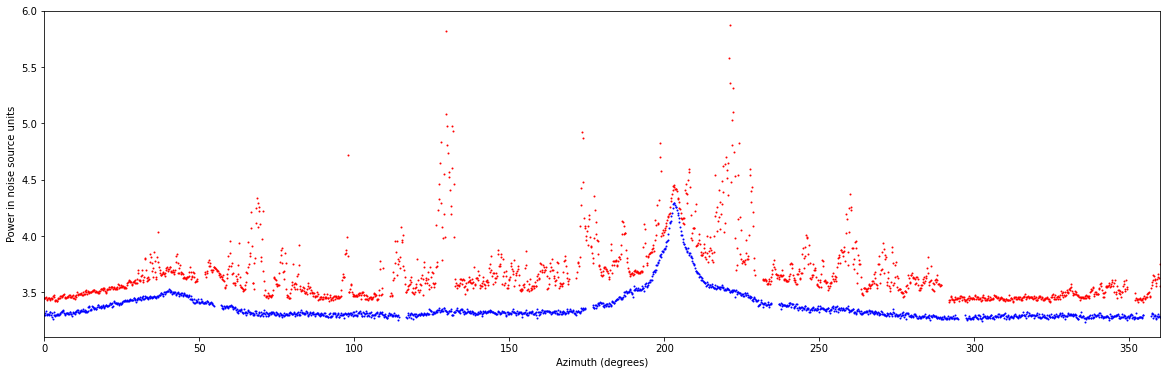

In [11]:
fig1, axs = plt.subplots(1,1,figsize=(20,6))

ii = 6000
t_plt1 = Time(t1, format='isot',scale='utc').mjd
t_plt2 = Time(t2, format='isot',scale='utc').mjd

axs.scatter(new_az,new_RR1[:, ii],s=1, color = "b")
axs.scatter(new_az,new_RR2[:, ii],s=1, color = "r")
#axs.set_ylim(1.5,2.5)
axs.set_xlim(0,360)
axs.set_xlabel('Azimuth (degrees)')
axs.set_ylabel('Power in noise source units')

print(freq1[ii]/1e6)
print(freq2[ii]/1e6)

# Waterfall View of Phase differences

Text(0, 0.5, 'Frequency (MHz)')

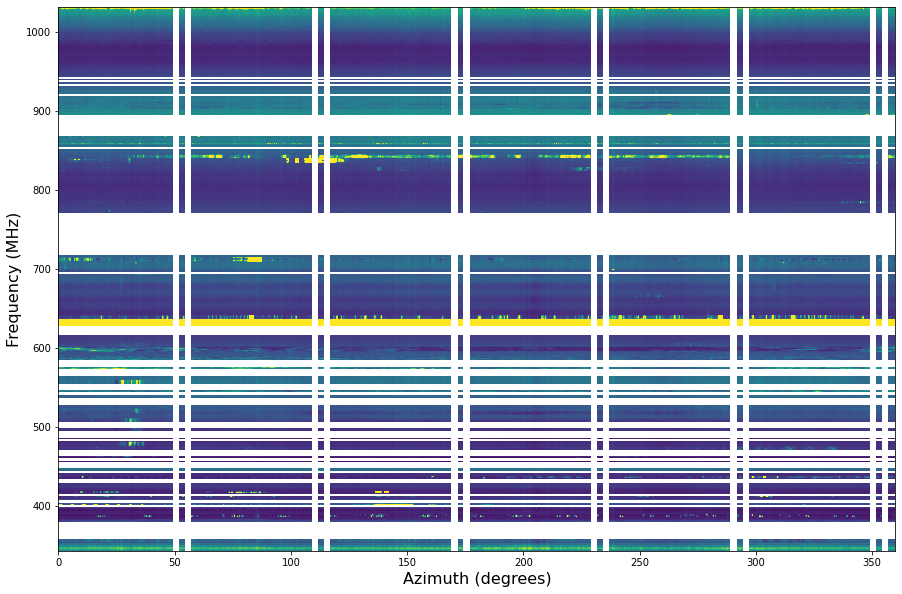

In [12]:
RR_diff = []
for freq_idx in range(0, len(RR1[0,:]-1)):
    rr_diff = np.abs(np.subtract(new_RR1[:,freq_idx],new_RR2[:,freq_idx]))
    RR_diff.append(rr_diff)
    
    
t_plt1 = Time(t1, format='isot',scale='utc').mjd
t_plt2 = Time(t2, format='isot',scale='utc').mjd

power_min = 0
power_max = 0.5
fig,axs = plt.subplots(1,1,figsize=(15,10)) 
fs = 16

extent = [az1[-1],az1[0],freq1[0]/1e6,freq1[-1]/1e6]

# im = axs.imshow(RR_diff,aspect='auto',vmin=power_min,vmax=power_max, origin='lower',extent=extent,cmap='viridis')
im = axs.imshow(RR_diff,aspect='auto',vmin=power_min,vmax=power_max, origin = 'lower', extent = extent, cmap = 'viridis')

axs.set_xlabel('Azimuth (degrees)',fontsize=fs)        
axs.set_ylabel('Frequency (MHz)',fontsize=fs)

b'2022-06-12T10:43:19.200005Z'
b'2022-08-27T05:44:30.000001Z'


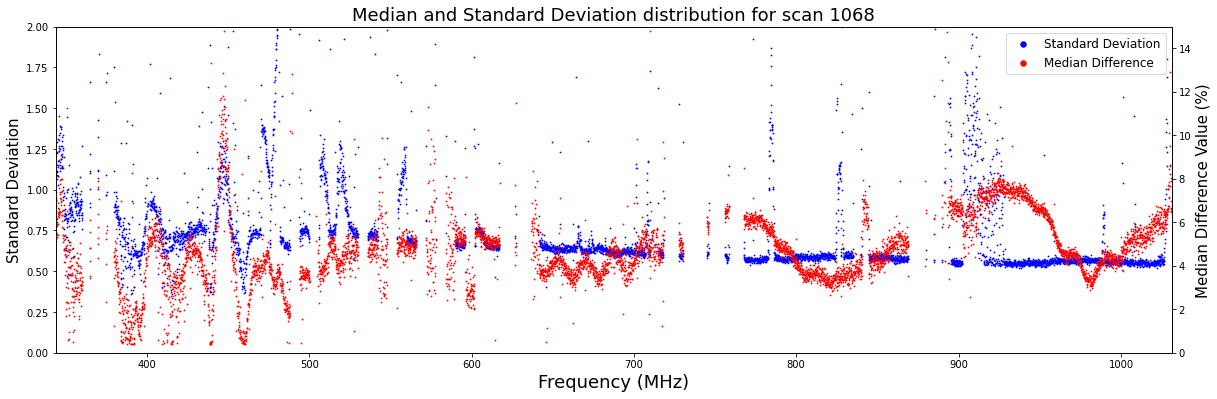

In [16]:
### User input - select scan from list above
# scan_pick = overlap_scans[1]
scan_pick = 1068
Write_Scan_Azimuth_Files(scan_pick)
################################################################################################

# Note: the following assumes we are only comparing a single scan from TWO phases of the survey.
# Will generalize this later to allow for three phase-comparison and better naming scheme for
# the data read in.
RR1,LL1,reRL1,imRL1,freq1,dec1,ra1,el1,az1,t1,noise1,trim_flag1 = read_in_scan(scan_pick,dir_files,1)
noise1_idx = np.array(np.where(noise1 == 1))
RR1[noise1_idx, :] = np.nan
RR1[:,RFI_mask_idx] = np.nan
LL1[noise1_idx, :] = np.nan
LL1[:,RFI_mask_idx] = np.nan


RR2,LL2,reRL2,imRL2,freq2,dec2,ra2,el2,az2,t2,noise2,trim_flag2 = read_in_scan(scan_pick,dir_files,2)
noise2_idx = np.array(np.where(noise2 == 1))
RR2[noise2_idx, :] = np.nan
RR2[:,RFI_mask_idx] = np.nan
LL2[noise2_idx, :] = np.nan
LL2[:,RFI_mask_idx] = np.nan

################################################################################################
#                                         Interpolation Step 
################################################################################################
new_az = np.linspace(0, 360, 1800)
new_RR1 = []
new_RR2 = []
new_LL1 = []
new_LL2 = []
for freq_idx in range(0, len(RR1[0, :])):
    # The interpolation function:
    rr_f1 = interpolate.interp1d(az1, RR1[:,freq_idx], fill_value='extrapolate')
    rr_f2 = interpolate.interp1d(az2, RR2[:,freq_idx], fill_value='extrapolate')
    ll_f1 = interpolate.interp1d(az1, LL1[:,freq_idx], fill_value='extrapolate')
    ll_f2 = interpolate.interp1d(az2, LL2[:,freq_idx], fill_value='extrapolate')

    
    # getting the 'new' y (power) interpolated over the evenly space az
    new_RR1.append(rr_f1(new_az))
    new_RR2.append(rr_f2(new_az))
    new_LL1.append(ll_f1(new_az))
    new_LL2.append(ll_f2(new_az))

new_RR1 = np.transpose(new_RR1)
new_RR2 = np.transpose(new_RR2)
new_LL1 = np.transpose(new_LL1)
new_LL2 = np.transpose(new_LL2)
################################################################################################

RR_median_arr = []
RR_std_arr = []
RR_rms_arr = []
fig, axs = plt.subplots(1,1,figsize=(20,6))


for freq_idx in range(0, len(freq1)):
    RR_frac_diff = Get_Percent_Diff(new_RR1[:, freq_idx], new_RR2[:, freq_idx])
    RR_median = np.nanmedian(RR_frac_diff)
    RR_median_arr.append(RR_median)
    
    RR_std = np.nanstd(RR_frac_diff)
    RR_std_arr.append(RR_std)
    
std_scatter = axs.scatter(np.divide(freq1, 1e6), RR_std_arr, s = 0.6, color = 'b', label = 'Standard Deviation')
axs.set_ylim(0, 2)
axs.set_ylabel("Standard Deviation", fontsize = 15)
axs.set_xlabel("Frequency (MHz)", fontsize = 18)
axs.set_xlim(np.nanmin(freq1)/1e6, np.nanmax(freq1)/1e6)
axs.legend(markerscale = 10)

axs2 = axs.twinx()
median_scatter = axs2.scatter(np.divide(freq1, 1e6), RR_median_arr, s = 0.6, color = 'r', label = 'Median Difference')
axs2.set_ylim(0, 15)
axs2.set_ylabel("Median Difference Value (%)", fontsize = 15)

combined_scatter = [std_scatter, median_scatter]
labels = [l.get_label() for l in combined_scatter]
axs.legend(combined_scatter, labels, loc = "upper right", markerscale = 7, fontsize = 12)
axs.set_title("Median and Standard Deviation distribution for scan {:d}".format(scan_pick), fontsize = 18)
plt.savefig("Median and Standard Deviation distribution for scan {:d}.png".format(scan_pick), facecolor = 'none')

In [14]:
for scan_idx in range(0, len(overlap_scans)):
    ### User input - select scan from list above
    scan_pick = overlap_scans[scan_idx]
#     Write_Scan_Azimuth_Files(scan_pick)
    ################################################################################################

    # Note: the following assumes we are only comparing a single scan from TWO phases of the survey.
    # Will generalize this later to allow for three phase-comparison and better naming scheme for
    # the data read in.
    RR1,LL1,reRL1,imRL1,freq1,dec1,ra1,el1,az1,t1,noise1,trim_flag1 = read_in_scan(scan_pick,dir_files,1)
    noise1_idx = np.array(np.where(noise1 == 1))
    RR1[noise1_idx, :] = np.nan
    RR1[:,RFI_mask_idx] = np.nan
    LL1[noise1_idx, :] = np.nan
    LL1[:,RFI_mask_idx] = np.nan


    RR2,LL2,reRL2,imRL2,freq2,dec2,ra2,el2,az2,t2,noise2,trim_flag2 = read_in_scan(scan_pick,dir_files,2)
    noise2_idx = np.array(np.where(noise2 == 1))
    RR2[noise2_idx, :] = np.nan
    RR2[:,RFI_mask_idx] = np.nan
    LL2[noise2_idx, :] = np.nan
    LL2[:,RFI_mask_idx] = np.nan

    ################################################################################################
    #                                         Interpolation Step 
    ################################################################################################
    new_az = np.linspace(0, 360, 1800)
    new_RR1 = []
    new_RR2 = []
    new_LL1 = []
    new_LL2 = []
    for freq_idx in range(0, len(RR1[0, :])):
        # The interpolation function:
        rr_f1 = interpolate.interp1d(az1, RR1[:,freq_idx], fill_value='extrapolate')
        rr_f2 = interpolate.interp1d(az2, RR2[:,freq_idx], fill_value='extrapolate')
        ll_f1 = interpolate.interp1d(az1, LL1[:,freq_idx], fill_value='extrapolate')
        ll_f2 = interpolate.interp1d(az2, LL2[:,freq_idx], fill_value='extrapolate')

    
        # getting the 'new' y (power) interpolated over the evenly space az
        new_RR1.append(rr_f1(new_az))
        new_RR2.append(rr_f2(new_az))
        new_LL1.append(ll_f1(new_az))
        new_LL2.append(ll_f2(new_az))

    new_RR1 = np.transpose(new_RR1)
    new_RR2 = np.transpose(new_RR2)
    new_LL1 = np.transpose(new_LL1)
    new_LL2 = np.transpose(new_LL2)
    ################################################################################################

    RR_median_arr = []
    RR_std_arr = []
    RR_rms_arr = []
    fig, axs = plt.subplots(1,1,figsize=(20,6))


    for freq_idx in range(0, len(freq1)):
        RR_frac_diff = Get_Percent_Diff(new_RR1[:, freq_idx], new_RR2[:, freq_idx])
        RR_median = np.nanmedian(RR_frac_diff)
        RR_median_arr.append(RR_median)
    
        RR_std = np.nanstd(RR_frac_diff)
        RR_std_arr.append(RR_std)
    
    std_scatter = axs.scatter(np.divide(freq1, 1e6), RR_std_arr, s = 0.6, color = 'b', label = 'Standard Deviation')
    axs.set_ylim(0, 2)
    axs.set_ylabel("Standard Deviation", fontsize = 15)
    axs.set_xlabel("Frequency (MHz)", fontsize = 18)
    axs.set_xlim(np.nanmin(freq1)/1e6, np.nanmax(freq1)/1e6)
    axs.legend(markerscale = 10)

    axs2 = axs.twinx()
    median_scatter = axs2.scatter(np.divide(freq1, 1e6), RR_median_arr, s = 0.6, color = 'r', label = 'Median')
    axs2.set_ylim(0, 15)
    axs2.set_ylabel("Median value", fontsize = 15)

    combined_scatter = [std_scatter, median_scatter]
    labels = [l.get_label() for l in combined_scatter]
    axs.legend(combined_scatter, labels, loc = "upper right", markerscale = 7, fontsize = 12)
    axs.set_title("Median and Standard Deviation distribution for scan {:d}".format(scan_pick), fontsize = 18)
    plt.savefig("Median and Standard Deviation distribution for scan {:d}.png".format(scan_pick))

KeyboardInterrupt: 